# Spaceship Titanic - Notebook

<!-- TODO -->


Import the necessary libraries. We will use:

- `pandas` to load the data and manipulate it.
- `scikit-learn` to build the model.
<!-- TODO - `matplotlib` and `seaborn` to plot the data. -->


In [89]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    RFE,
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from featuretools import EntitySet, dfs

In [90]:
# Define constants
CURRENT_DIR = os.getcwd()

DATA_DIR = f"{CURRENT_DIR}/data"
TRAIN_DATA_FILE = f"{DATA_DIR}/train.csv"
TEST_DATA_FILE = f"{DATA_DIR}/test.csv"

TARGET_COLUMN = "Transported"
ID_COLUMN = "PassengerId"

RANDOM_SEED = 42
VALIDATION_SIZE = 0.2

MISSING_VALUE = "Missing"

In [91]:
# Load the data files into pandas dataframes
train_data = pd.read_csv(TRAIN_DATA_FILE)
test_data = pd.read_csv(TEST_DATA_FILE)

## Data Exploration


In [92]:
print("First few rows of data:")
display(train_data.head())

First few rows of data:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [93]:
print("Data columns and types:")
print(train_data.dtypes)

Data columns and types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [94]:
NUMERICAL_COLUMNS = train_data.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_COLUMNS = train_data.select_dtypes(include=["object"]).columns.tolist()


leftover_columns = [
    col
    for col in train_data.columns
    if col not in NUMERICAL_COLUMNS
    and col not in CATEGORICAL_COLUMNS
    and col != TARGET_COLUMN
]
assert not leftover_columns

In [95]:
print(f"Numerical columns: {NUMERICAL_COLUMNS}")
print(f"Categorical columns: {CATEGORICAL_COLUMNS}")
print(f"Target column: {TARGET_COLUMN}")

Numerical columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
Target column: Transported


In [96]:
print("\nSummary statistics:")
display(train_data.describe())

print("\nMissing values:")
print(train_data.isnull().sum())

# print("\nCorrelation matrix:")
# sns.heatmap(train_data[NUMERICAL_COLUMNS].corr(), annot=True)
# plt.show()

print("\nValue counts for categorical variables:")
for col in CATEGORICAL_COLUMNS:
    print(f"\n{col} value counts:")
    print(train_data[col].value_counts())


Summary statistics:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Value counts for categorical variables:

PassengerId value counts:
PassengerId
9280_02    1
0001_01    1
0002_01    1
0003_01    1
0003_02    1
          ..
0008_01    1
0007_01    1
0006_02    1
0006_01    1
0005_01    1
Name: count, Length: 8693, dtype: int64

HomePlanet value counts:
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

CryoSleep value counts:
CryoSleep
False    5439
True     3037
Name: count, dtype: int64

Cabin value counts:
Cabin
G/734/S     8
B/11/S      7
F/1411/P    7
B/82/S      7
G/981/S     7
           ..
G/543/S     1
B/106/P     1
G/542/S     1
F/700/P     1
G/559/P     1
Name: count, Length: 6560, dtype: int64

Destinat

In [97]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


## Clean Dataset

We need to clean the train and test datasets the same way


In [98]:
def clean_data(data: pd.DataFrame):

    data = data.copy()

    # Convert columns to integer (with missing values)
    for col in [
        "CabinNumber",
        "CryoSleep",
        "VIP",
        "Transported",
        "PassengerGroupId",
        "PassengerIntraGroupId",
    ]:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors="coerce").astype("Int64")

    # Make PassengerId the index
    data.set_index(ID_COLUMN, inplace=True)

    # Drop columns
    for col in [
        "Name",
        "Cabin",
        "PassengerGroupId",
        "PassengerIntraGroupId",
    ]:
        if col in data.columns:
            data.drop(columns=col, inplace=True)

    return data

In [99]:
# train_data = clean_data(train_data)
# test_data = clean_data(test_data)

## Create Features


In [100]:
def create_features(data: pd.DataFrame):

    data = data.copy()

    # Create new feature: Total money spent in the ship's service
    data["AmountSpentTotal"] = data[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].sum(axis=1, skipna=True)

    # Create new feature: Mean money spent in the ship's service
    # data["AmountSpentMean"] = data[
    #     ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    # ].mean(axis=1, skipna=True)

    # Create new features: Convert Cabin to three different columns (Deck, Number, Side)
    data[["CabinDeck", "CabinNumber", "CabinSide"]] = data["Cabin"].str.split(
        "/", expand=True
    )

    # Create new feature: Number of people in the same cabin
    data["CabinMates"] = data.groupby("Cabin")["Cabin"].transform("count")

    # Create new features: Group Id, Group Size, Intra Group Id,
    data[["PassengerGroupId", "PassengerIntraGroupId"]] = data[ID_COLUMN].str.split(
        "_", expand=True
    )
    data["PassengerGroupSize"] = data.groupby("PassengerGroupId")[
        "PassengerGroupId"
    ].transform("count")

    return data

In [101]:
# train_data = create_features(train_data)
# test_data = create_features(test_data)

In [102]:
pipeline = Pipeline(
    [
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
    ]
)

In [103]:
train_data_transformed_df = pipeline.fit_transform(train_data)
print(train_data_transformed_df.dtypes)

HomePlanet             object
CryoSleep               Int64
Destination            object
Age                   float64
VIP                     Int64
RoomService           float64
FoodCourt             float64
ShoppingMall          float64
Spa                   float64
VRDeck                float64
Transported             Int64
AmountSpentTotal      float64
CabinDeck              object
CabinNumber             Int64
CabinSide              object
CabinMates            float64
PassengerGroupSize      int64
dtype: object


## Data Preprocessing Pipeline

### Handle Missing Values

- Input Data
- Mark as "Missing"

### Data Preprocessing

- Make Categorical Columns Numerical
  - One-Hot encoding
  - Ordinal encoding
- Scale Numerical Columns


In [104]:
MAX_CARDINALITY = 4


def select_high_cardinality_categorical_features(df: pd.DataFrame):
    hi_c_cat = df.select_dtypes(include=["object"]).nunique() > MAX_CARDINALITY
    features = hi_c_cat[hi_c_cat].index.tolist()
    return features


def select_low_cardinality_categorical_features(df: pd.DataFrame):
    lo_c_cat = df.select_dtypes(include=["object"]).nunique() <= MAX_CARDINALITY
    features = lo_c_cat[lo_c_cat].index.tolist()
    return features


def select_numerical_features(df: pd.DataFrame):
    return df.select_dtypes(include=[np.number]).columns.tolist()


# Combine handling missing values and preprocessing into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat_low_cardinality",
            Pipeline(
                steps=[
                    (
                        "impute",
                        # SimpleImputer(strategy="most_frequent"),
                        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
                    ),
                    (
                        "to_num",
                        OneHotEncoder(),
                        # OrdinalEncoder(),
                        # LabelEncoder(),
                    ),
                ]
            ),
            select_low_cardinality_categorical_features,
        ),
        (
            "cat_high_cardinality",
            Pipeline(
                steps=[
                    (
                        "impute",
                        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
                        # SimpleImputer(strategy="most_frequent"),
                    ),
                    (
                        "to_num",
                        # OneHotEncoder(),
                        OrdinalEncoder(),
                        # LabelEncoder(),
                    ),
                ]
            ),
            select_high_cardinality_categorical_features,
        ),
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "impute",
                        # KNNImputer(n_neighbors=1),
                        # KNNImputer(n_neighbors=3),
                        KNNImputer(n_neighbors=5),
                        # SimpleImputer(strategy="mean"),
                        # SimpleImputer(strategy="median"),
                    ),
                    (
                        "scale",
                        StandardScaler(),
                        # MinMaxScaler(),
                        # RobustScaler(),
                    ),
                ]
            ),
            select_numerical_features,
        ),
    ],
    remainder="passthrough",
    # sparse_threshold=0,
)

# preprocessor.set_output(transform="pandas")

In [105]:
pipeline = Pipeline(
    steps=[
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
        ("preprocessor", preprocessor),
    ]
)

In [106]:
def transform_data(data: pd.DataFrame, pipeline: Pipeline) -> pd.DataFrame:
    X = data.drop(columns=[TARGET_COLUMN])
    y = data[TARGET_COLUMN]

    # Fit and transform the data using the pipeline
    data_transformed = pipeline.fit_transform(X=X, y=y)

    # Extract feature names from the preprocessor step
    if "preprocessor" in pipeline.named_steps:
        feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    else:
        feature_names = data.columns

    # Extract the selected feature indices from the feature engineering step
    if "feature_engineering" in pipeline.named_steps:
        feature_selector = pipeline.named_steps["feature_engineering"].named_steps[
            "feature_selection"
        ]
        if isinstance(feature_selector, SelectFromModel):
            support_mask = feature_selector.get_support()
        elif isinstance(feature_selector, RFE):
            support_mask = feature_selector.support_
        else:
            support_mask = np.ones(len(feature_names), dtype=bool)
        selected_feature_names = [
            name for name, selected in zip(feature_names, support_mask) if selected
        ]
    else:
        selected_feature_names = feature_names

    # Remove prefixes from the column names
    selected_feature_names = [name.split("__")[-1] for name in selected_feature_names]

    # Convert the transformed data back to a DataFrame
    data_transformed_df = pd.DataFrame(data_transformed, columns=selected_feature_names)

    data_transformed_df[TARGET_COLUMN] = y.values

    return data_transformed_df

In [107]:
# Use the function to transform the train_data
train_data_transformed_df = transform_data(train_data, pipeline)

### Check Preprocessing Works

- Check if no missing values after preprocessing
- Check if all columns are numerical after preprocessing


In [108]:
# Check for missing values

print("Number of missing values in transformed data:")
display(pd.DataFrame(train_data_transformed_df.isna().sum()).T)

assert train_data_transformed_df.isna().sum().sum() == 0

Number of missing values in transformed data:


,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinSide_Missing,CabinSide_P,...,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,AmountSpentTotal,CabinNumber,CabinMates,PassengerGroupSize,Transported
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# Check all columns are numerical

all_columns_numerical = train_data_transformed_df.select_dtypes(
    include=[np.number]
).columns.tolist()
all_columns = train_data_transformed_df.columns.tolist()

columns_not_numerical = (
    set(all_columns) - set(all_columns_numerical) - set([TARGET_COLUMN])
)
print(f"Columns not numerical: {columns_not_numerical}")

# Output the types of the non-numerical columns
for col in columns_not_numerical:
    print(
        f"Column: {col}, Type: {train_data_transformed_df[col].dtype}, First Value: {train_data_transformed_df[col].iloc[0]}"
    )

assert columns_not_numerical == set()

Columns not numerical: set()


## Feature Engineering


In [110]:
feature_engineering = Pipeline(
    steps=[
        # ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
        # ("feature_selection", RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED))),
        # ("feature_selection", RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED), n_features_to_select=10)),
        ("feature_selection", SelectFromModel(LassoCV(cv=5, random_state=RANDOM_SEED))),
        # ("feature_selection", SelectKBest(f_classif, k=10)),
        # ("feature_selection", SelectKBest(mutual_info_classif, k=10)),
        # ("feature_selection", SelectKBest(f_classif, k=20)),
        # ("feature_selection", SelectKBest(mutual_info_classif, k=20)),
        # ("feature_selection", SelectFromModel(RandomForestClassifier(random_state=RANDOM_SEED), threshold="mean")),
    ]
)

In [111]:
# Add the feature engineering pipeline to the main pipeline
pipeline = Pipeline(
    steps=[
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
        ("preprocessor", preprocessor),
        ("feature_engineering", feature_engineering),
    ]
)

In [112]:
# Use the function to transform the train_data
train_data_transformed_df = transform_data(train_data, pipeline)

In [113]:
train_data_transformed_df.columns

Index(['HomePlanet_Earth', 'HomePlanet_Europa', 'Destination_55 Cancri e',
       'Destination_TRAPPIST-1e', 'CabinSide_P', 'CabinSide_S', 'CabinDeck',
       'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'CabinNumber', 'CabinMates', 'Transported'],
      dtype='object')

## Analyze Correlation on Transformed Dataset


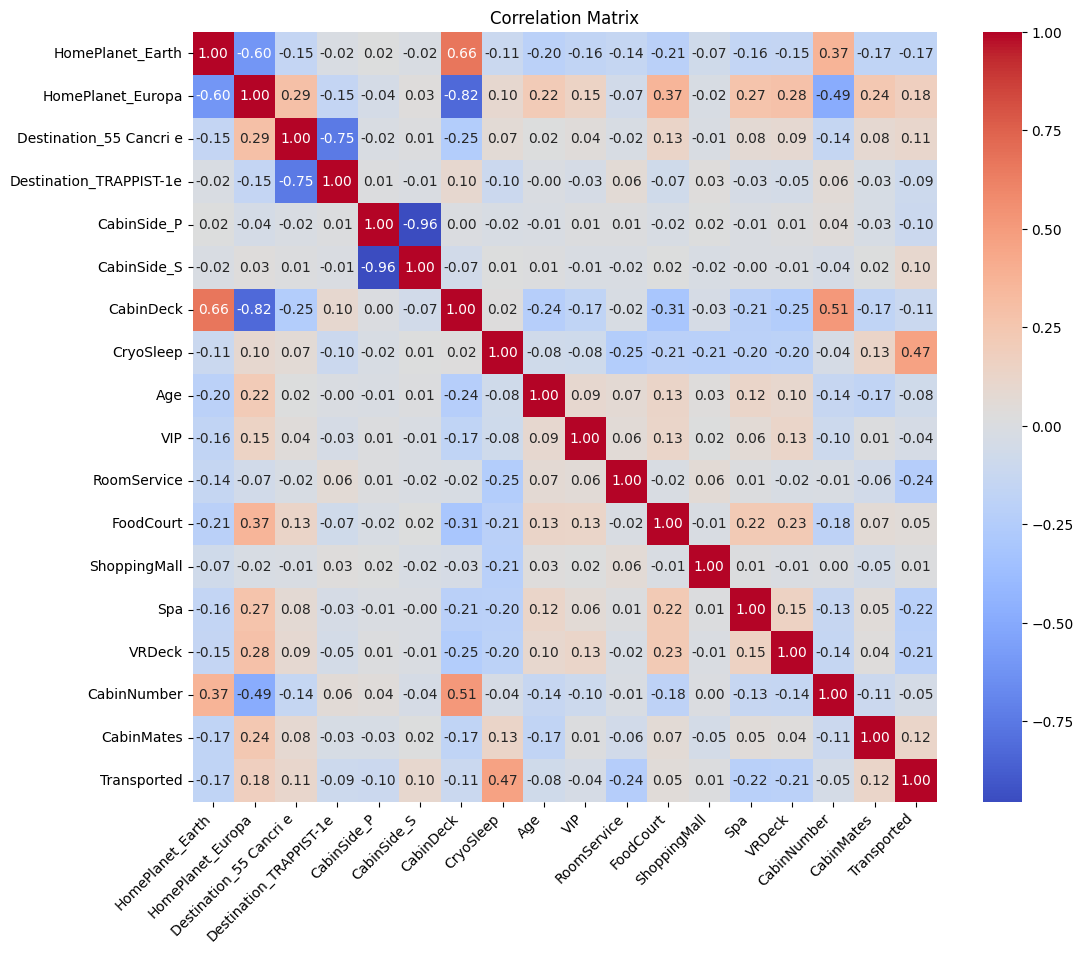

In [114]:
corr_matrix = train_data_transformed_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=train_data_transformed_df.columns.tolist(),
    yticklabels=train_data_transformed_df.columns.tolist(),
)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

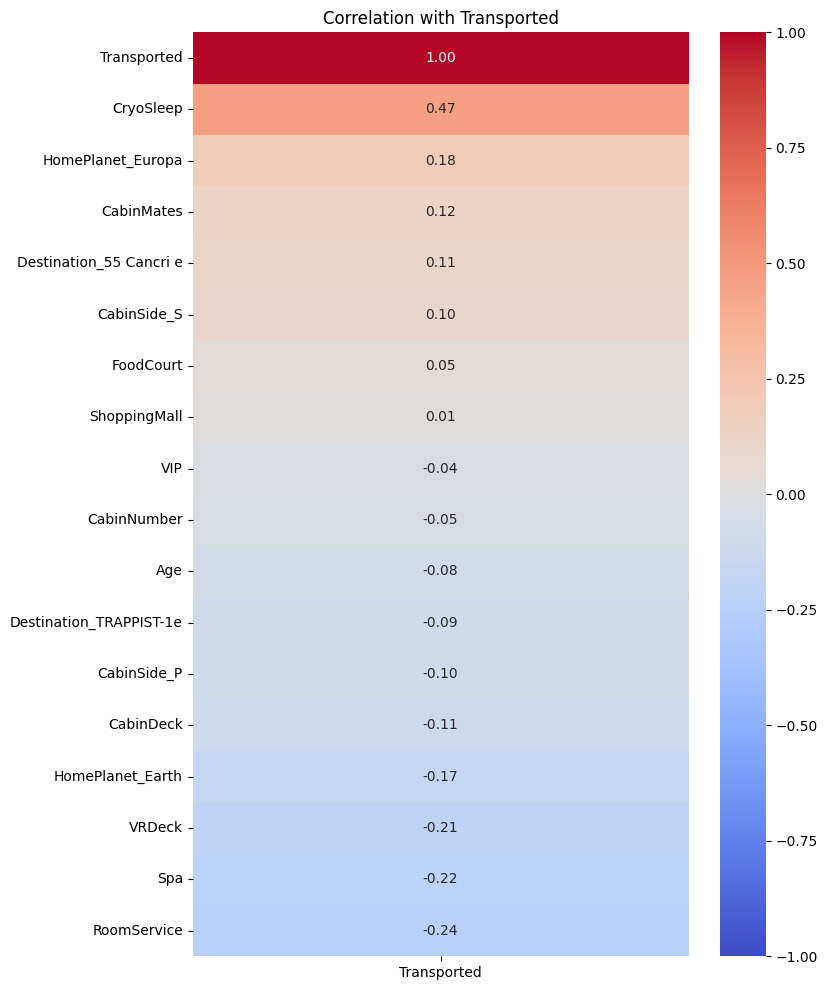

In [115]:
# Filter the correlation matrix to only include the Target Column
target_corr_matrix = corr_matrix[[TARGET_COLUMN]].sort_values(
    by=TARGET_COLUMN, ascending=False
)

plt.figure(figsize=(8, 12))
sns.heatmap(target_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Correlation with {TARGET_COLUMN}")
plt.show()

## Tuning Grids


In [116]:
# Main pipeline

pipeline = Pipeline(
    steps=[
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
        ("preprocessor", preprocessor),
        ("feature_engineering", feature_engineering),
        ("classifier", "passthrough"),
    ]
)

# Note: "passthrough" is used as a placeholder for the model to be used

### Preprocessor Grids

2 _ 2 _ 5 = 20
Fitting 5 folds for each of 120 candidates, totalling 600 fits
11 min 51 s


In [117]:
preprocessor_grid = {
    "preprocessor__cat_low_cardinality__impute": [
        # SimpleImputer(strategy="most_frequent"), #
        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
    ],
    "preprocessor__cat_low_cardinality__to_num": [
        OneHotEncoder(),
        OrdinalEncoder(), #
    ],
    "preprocessor__cat_high_cardinality__impute": [
        # SimpleImputer(strategy="most_frequent"), #
        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
    ],
    "preprocessor__cat_high_cardinality__to_num": [
        OneHotEncoder(),  # TODO works better?
        OrdinalEncoder(), #
    ],
    "preprocessor__num__impute": [
        # KNNImputer(n_neighbors=1), #
        KNNImputer(n_neighbors=3), #
        KNNImputer(n_neighbors=5),  #
        SimpleImputer(strategy="mean"), #
        SimpleImputer(strategy="median"),
    ],
    "preprocessor__num__scale": [
        StandardScaler(),
        # MinMaxScaler(), #
        # RobustScaler(), #
    ],
}

### Feature Engineering Grid


In [118]:
feature_engineering_grid = {
    "create_features": [
        FunctionTransformer(create_features),
        # "passthrough",
    ],
    "feature_engineering__feature_selection": [
        # RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED)),
        # RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED), n_features_to_select=10),
        SelectFromModel(LassoCV(cv=5, random_state=RANDOM_SEED)),
        # SelectKBest(f_classif, k=10),
        # SelectKBest(mutual_info_classif, k=10),
        # SelectKBest(f_classif, k=20),
        # SelectKBest(mutual_info_classif, k=20),
        # SelectFromModel(RandomForestClassifier(random_state=RANDOM_SEED), threshold="mean"),
        "passthrough",
    ],
}

### Model Grid

6 + 3 + 6 + 6 + 8 = 29
Fitting 5 folds for each of 29 candidates, totalling 145 fits
3 min 45s


In [119]:
model_grids = [
    # {
    #     # Logistic Regression
    #     "classifier": [LogisticRegression()],
    #     "classifier__C": [0.01, 0.1, 1, 10, 100],
    #     "classifier__penalty": ["l1", "l2"],
    #     "classifier__solver": ["liblinear", "saga"],
    # },
    # {
    #     # Decision Tree
    #     "classifier": [DecisionTreeClassifier(random_state=RANDOM_SEED)],
    #     "classifier__max_depth": [None, 10, 20, 30],
    #     "classifier__min_samples_split": [2, 5, 10],
    #     "classifier__min_samples_leaf": [1, 2, 4],
    # },
    # {
    #     # Random Forest
    #     "classifier": [RandomForestClassifier(random_state=RANDOM_SEED)],
    #     "classifier__n_estimators": [100, 200, 300],
    #     "classifier__max_depth": [None, 10, 20, 30],
    #     "classifier__min_samples_split": [2, 5, 10],
    #     "classifier__min_samples_leaf": [1, 2, 4],
    # },
    # {
    #     # K-Nearest Neighbors
    #     "classifier": [KNeighborsClassifier()],
    #     "classifier__n_neighbors": [3, 5, 7, 9, 11],
    #     "classifier__weights": ["uniform", "distance"],
    #     "classifier__metric": ["euclidean", "manhattan"],
    # },
    # {
    #     # Support Vector Machine
    #     "classifier": [SVC(probability=True)],
    #     "classifier__C": [0.01, 0.1, 1, 10],
    #     "classifier__kernel": ["linear", "rbf", "poly"],
    #     "classifier__gamma": ["scale", "auto"],
    # },
    # {
    #     # Gradient Boosting
    #     "classifier": [GradientBoostingClassifier(random_state=RANDOM_SEED)],
    #     "classifier__n_estimators": [100, 150, 200, 250, 300, 500],
    #     "classifier__learning_rate": [0.05, 0.1, 0.15, 0.2],
    #     "classifier__max_depth": [3, 5, 7],
    #     "classifier__subsample": [0.8, 1.0],
    # },
    # {
    #     # XGBoost
    #     "classifier": [XGBClassifier(random_state=RANDOM_SEED)],
    #     "classifier__n_estimators": [100, 250, 500],
    #     "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    #     "classifier__max_depth": [3, 6, 9],
    #     "classifier__subsample": [0.8, 1.0],
    #     "classifier__colsample_bytree": [0.8, 1.0],
    # },
    # {
    #     # LightGBM
    #     "classifier": [LGBMClassifier(random_state=RANDOM_SEED, verbose=-1)],
    #     "classifier__n_estimators": [100, 250, 500],
    #     "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    #     "classifier__max_depth": [3, 6, 9],
    #     "classifier__subsample": [0.8, 1.0],
    #     "classifier__colsample_bytree": [0.8, 1.0],
    # },
]

In [120]:
model_grids = [
    {
        # Gradient Boosting
        "classifier": [GradientBoostingClassifier(random_state=RANDOM_SEED)],
        "classifier__n_estimators": [200, 250, 300],
        "classifier__learning_rate": [0.05, 0.1, 0.15],
        "classifier__max_depth": [1, 3, 5],
        "classifier__subsample": [0.8, 1.0],
    },
]

### Final Grid Search


In [121]:
parameter_grids = []

for m in model_grids:
    grid = m
    grid.update(preprocessor_grid)
    grid.update(feature_engineering_grid)
    parameter_grids.append(grid)

## Model Training and Parameter Grid Search


In [122]:
# # Split the train data into training and validation sets
# X = train_data.drop(columns=[TARGET_COLUMN])
# y = train_data[TARGET_COLUMN]

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=VALIDATION_SIZE, random_state=RANDOM_SEED
# )

In [123]:
# Split the train data into training and validation sets
X_train = train_data.drop(columns=[TARGET_COLUMN])
y_train = train_data[TARGET_COLUMN]

In [124]:
# Run experiments
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameter_grids,
    cv=5,  # TODO parametrize
    scoring="accuracy",
    verbose=1,
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


/home/javier/.cache/pypoetry/virtualenvs/spaceship-titanic-UUL0AmCy-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14000569232280213, tolerance: 0.13885151896458733
  model = cd_fast.enet_coordinate_descent_gram(
/home/javier/.cache/pypoetry/virtualenvs/spaceship-titanic-UUL0AmCy-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1643343877449297, tolerance: 0.13885151896458733
  model = cd_fast.enet_coordinate_descent_gram(
/home/javier/.cache/pypoetry/virtualenvs/spaceship-titanic-UUL0AmCy-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

KeyboardInterrupt: 

In [80]:
def print_model_parameters(params):
    for k, v in params.items():
        print(f"  {k:<50}: {v}")

#### Best so far

```
Best Model:
classifier                                        : GradientBoostingClassifier(random_state=42)
classifier__learning_rate                         : 0.1
classifier__n_estimators                          : 250
preprocessor__cat_onehot__impute                  : SimpleImputer(fill_value='Missing', strategy='constant')
preprocessor__cat_onehot__onehot                  : OneHotEncoder()
preprocessor__cat_ordinal__impute                 : SimpleImputer(fill_value='Missing', strategy='constant')
preprocessor__cat_ordinal__ordinal                : OneHotEncoder()
preprocessor__num__impute                         : SimpleImputer(strategy='median')
preprocessor__num__scale                          : StandardScaler()
```


#### Best model for current execution


In [81]:
# grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Model:")
print_model_parameters(best_params)

Best Model:
  classifier                                        : GradientBoostingClassifier(random_state=42)
  classifier__learning_rate                         : 0.1
  classifier__max_depth                             : 3
  classifier__n_estimators                          : 300
  classifier__subsample                             : 1.0
  create_features                                   : FunctionTransformer(func=<function create_features at 0x7c929ba14540>)
  feature_engineering__feature_selection            : passthrough
  preprocessor__cat_high_cardinality__impute        : SimpleImputer(fill_value='Missing', strategy='constant')
  preprocessor__cat_high_cardinality__to_num        : OneHotEncoder()
  preprocessor__cat_low_cardinality__impute         : SimpleImputer(fill_value='Missing', strategy='constant')
  preprocessor__cat_low_cardinality__to_num         : OneHotEncoder()
  preprocessor__num__impute                         : KNNImputer()
  preprocessor__num__scale              

#### All models for current execution


In [ ]:
# Assuming grid_search is your GridSearchCV object
all_estimators_with_scores = list(
    zip(grid_search.cv_results_["params"], grid_search.cv_results_["mean_test_score"])
)

# Sort the estimators by their scores in descending order
all_estimators_with_scores.sort(key=lambda x: x[1], reverse=True)

# Print all estimators with their scores and ranking
for rank, (estimator, score) in enumerate(all_estimators_with_scores, start=1):
    print(f"Rank: {rank}")
    print(f"Accuracy: {score}")
    print("Model:")
    print_model_parameters(estimator)
    print("\n")

Rank: 1
Accuracy: 0.8156459045560102
Model:
  classifier                                        : GradientBoostingClassifier(random_state=42)
  classifier__learning_rate                         : 0.1
  classifier__max_depth                             : 3
  classifier__n_estimators                          : 300
  classifier__subsample                             : 1.0
  create_features                                   : FunctionTransformer(func=<function create_features at 0x7c929ba14540>)
  feature_engineering__feature_selection            : passthrough
  preprocessor__cat_high_cardinality__impute        : SimpleImputer(fill_value='Missing', strategy='constant')
  preprocessor__cat_high_cardinality__to_num        : OneHotEncoder()
  preprocessor__cat_low_cardinality__impute         : SimpleImputer(fill_value='Missing', strategy='constant')
  preprocessor__cat_low_cardinality__to_num         : OneHotEncoder()
  preprocessor__num__impute                         : KNNImputer()
  prepro

In [83]:
# Save the best (in train) model parameters to a JSON file
best_params_file = f"{DATA_DIR}/best_params_train.json"

# Convert non-serializable objects to their string representations
serializable_best_params = {k: str(v) for k, v in best_params.items()}

with open(best_params_file, "w") as f:
    json.dump(serializable_best_params, f, indent=4)

## Best Model Evaluation with Validation Set


In [84]:
def evaluate_model(pipeline, estimator, X_val, y_val):
    y_pred = pipeline.predict(X_val)
    y_pred_proba = (
        pipeline.predict_proba(X_val)[:, 1]
        if hasattr(pipeline, "predict_proba")
        else None
    )
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None

    print(f"Accuracy: {accuracy}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc}")
    # print(classification_report(y_val, y_pred))
    print("Model:")
    print_model_parameters(estimator)

    return accuracy

In [ ]:
# # Evaluate all estimators in grid search with validation set
# for estimator, _ in all_estimators_with_scores:
#     pipeline.set_params(**estimator)
#     pipeline.fit(X_train, y_train)
#     score = evaluate_model(pipeline, estimator, X_val, y_val)

Accuracy: 0.7924094307073031
ROC AUC: 0.8961251815577056
Model:
  classifier                                        : GradientBoostingClassifier(n_estimators=300, random_state=42)
  classifier__learning_rate                         : 0.1
  classifier__max_depth                             : 3
  classifier__n_estimators                          : 300
  classifier__subsample                             : 1.0
  create_features                                   : FunctionTransformer(func=<function create_features at 0x7c929ba14540>)
  feature_engineering__feature_selection            : passthrough
  preprocessor__cat_high_cardinality__impute        : SimpleImputer(fill_value='Missing', strategy='constant')
  preprocessor__cat_high_cardinality__to_num        : OneHotEncoder()
  preprocessor__cat_low_cardinality__impute         : SimpleImputer(fill_value='Missing', strategy='constant')
  preprocessor__cat_low_cardinality__to_num         : OneHotEncoder()
  preprocessor__num__impute          

## Final Model Training and Submission


In [ ]:
# Retrain the best model on the full training data
best_model = grid_search.best_estimator_
# best_model.fit(X, y)
best_model.fit(X_train, y_train)


Pipeline(steps=[('create_features',
                 FunctionTransformer(func=<function create_features at 0x7c929ba14540>)),
                ('clean_data',
                 FunctionTransformer(func=<function clean_data at 0x7c929ba15ee0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_low_cardinality',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='co...
                                                  <function select_high_cardinality_categorical_features at 0x7c929ba17c40>),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <function select_numerical_features at 0x7c929ba14d60>)])),
                ('feature_engineering',
                 Pipeline(steps=[('feature_selection', 'passthrough')])),
                ('classifier',
                 GradientBoostingClassifier(n_estimators=300,
                                            random_state=42))])

In [87]:
# Make predictions on the test data
X_test = test_data
y_pred = best_model.predict(X_test)
test_data[TARGET_COLUMN] = y_pred.astype(bool)

# Make predictions on the test set with the best model
# best_model = max(best_models.items(), key=lambda x: cross_val_score(x[1], X_train, y_train, cv=5).mean())[1]
# test_predictions = best_model.predict(test_data)
# test_data[TARGET_COLUMN] = test_predictions.astype(bool)

In [88]:
# Create a DataFrame with only the ID_COLUMN and Predictions
predictions_df = test_data.reset_index()[[ID_COLUMN, TARGET_COLUMN]]

# Print predictions
print(predictions_df)

# Save predictions to a CSV file
predictions_df.to_csv(f"{DATA_DIR}/predictions.csv", index=False)

     PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


## TODO

- Exploratory Data Analysis:
  - Data visualization
  - Find missing values
  - Find outliers, extreme or unusual values
  - Correlation analysis between numerical attributes and the target variable
  - For better data fitting, a more detailed analysis of each categorical variable is necessary.
- Data Preparation:
  - Data cleaning
  - Handle: outliers, extreme or unusual values
  - Missing values (removal, transformation, imputation, etc.)
  - Transform categorical variables into numerical (e.g., one-hot encoding)
  - (?) Transform numerical variables into categorical (e.g., discretization)
  - Feature engineering:
    - Create new attributes from existing ones to improve data description and reduce dimensionality.
    - It may also be interesting to create new attributes based on the interaction of highly correlated variables.
  - Feature selection
  - Instance selection
- Model Training:
  - Cross-validation
  - Grid search
- Model Evaluation:
  - Evaluation metrics
  - Model comparison
- Results Presentation:
  - Results visualization
  - Results interpretation
